### Imports

In [1]:
# Imports
import csv
import gc
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numba import njit, prange

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.decomposition import PCA

/home/ghaida/Desktop/AMLAS/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Download

In [2]:
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Download only if not already downloaded
if not os.path.exists(zip_file) and not os.path.exists(extract_folder):
    !wget -q $url
    print("Download complete.")
else:
    print("File already downloaded or extracted. Skipping download.")

# Extract only if not already extracted
if not os.path.exists(extract_folder):
    print(f"Unzipping {zip_file}...")
    !unzip -q $zip_file
    print(f"Successfully unzipped to '{extract_folder}' folder.")
else:
    print(f"'{extract_folder}' already exists. Skipping unzip.")

# List contents
if os.path.exists(extract_folder):
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: Folder '{extract_folder}' not found after extraction.")

# Clean up the zip file if it still exists
if os.path.exists(zip_file):
    print(f"\nCleaning up {zip_file}...")
    os.remove(zip_file)
    print("Zip file removed.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
File already downloaded or extracted. Skipping download.
'ml-32m' already exists. Skipping unzip.

Contents of ml-32m:
total 934187
-rw-rw-r-- 1 ghaida people       178 Oct 13  2023 checksums.txt
-rw-rw-r-- 1 ghaida people   1950748 Oct 13  2023 links.csv
-rw-rw-r-- 1 ghaida people   4242926 Oct 13  2023 movies.csv
-rw-rw-r-- 1 ghaida people 877076222 Oct 13  2023 ratings.csv
-rw-rw-r-- 1 ghaida people      9227 Oct 13  2023 README.txt
-rw-rw-r-- 1 ghaida people  72353890 Oct 13  2023 tags.csv


## Old Data Structure Class

In [8]:
class RatingsData:
    def __init__(self, file_path):
        self.file_path = file_path

        # ID mappings ( row Id <-> Matrix index)
        self.user_id_to_idx = {}
        self.idx_to_user_id = []
        self.movie_id_to_idx = {}
        self.idx_to_movie_id = []

        # Data storage
        self.data_by_user = []
        self.data_by_movie = []

    def load(self):
        """
        Loads data in two passes:
        1. Scan to establish dimensions and mappings.
        2. Populate the data structures with rating tuples.
        """
        user_set = set()
        movie_set = set()

        # First pass: Scan file to identify all unique entities for pre-allocation
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                user_set.add(int(row[0]))
                movie_set.add(int(row[1]))

        # Sort and map IDs
        # To ensure that the index mapping is deterministic every time
        self.idx_to_user_id = sorted(list(user_set))
        self.idx_to_movie_id =sorted(list(movie_set))

        # Create O(1) lookup dictionaries
        self.user_id_to_idx = {uid: i for i, uid in enumerate(self.idx_to_user_id)}
        self.movie_id_to_idx = {mid: i for i, mid in enumerate(self.idx_to_movie_id)}

        # Initialize data lists
        self.data_by_user = [[] for _ in range(len(self.idx_to_user_id))]
        self.data_by_movie = [[] for _ in range(len(self.idx_to_movie_id))]

        # # Fill the lists with rating data
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                user_id = int(row[0])
                movie_id = int(row[1])
                rating = float(row[2])

                # Resolve internal indices
                u_idx = self.user_id_to_idx[user_id]
                m_idx = self.movie_id_to_idx[movie_id]

                # Store (ID, Rating)
                self.data_by_user[u_idx].append((movie_id, rating))
                self.data_by_movie[m_idx].append((user_id, rating))


    def get_user_ratings(self, user_id):
        """
        Retrieve all ratings given by a specific user
        """
        u_idx = self.user_id_to_idx[user_id]
        return self.data_by_user[u_idx]

    def get_movie_ratings(self, movie_id):
        """
        Retrieve all ratings for a specific movie
        """
        m_idx = self.movie_id_to_idx[movie_id]
        return self.data_by_movie[m_idx]

    def num_users(self):
        return len(self.idx_to_user_id)

    def num_movies(self):
        return len(self.idx_to_movie_id)


### Load Data

In [9]:
file_path = "ml-32m/ratings.csv"
data = RatingsData(file_path)
data.load()

## Optimized MovieLens 32M Data Loader

Replaces the two-pass RatingsData class with single-pass CSR-based indexing.
Memory efficient (uses int32/float32)


In [3]:
def load_movielens_optimized(csv_path, test_fraction=0.1, random_seed=42):
    """
    Load MovieLens data with train/test split and CSR indexing.
    
    This is a DROP-IN replacement for your RatingsData class + splitting code.
    
    Parameters
    ----------
    csv_path : str
        Path to ratings.csv file
    test_fraction : float
        Fraction of ratings to use for testing (default: 0.1 = 10%)
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -------
    Dictionary containing:
        - n_users, n_movies : int
        - idx_to_user_id, idx_to_movie_id : arrays (for reverse mapping)
        - train_ratings_by_user, user_train_start
        - test_ratings_by_user, user_test_start
        - train_ratings_by_movie, movie_train_start
        - test_ratings_by_movie, movie_test_start
        - Helper functions: get_user_train_ratings, etc.
    """
    
    print("="*70)
    print("LOADING MOVIELENS DATA")
    print("="*70)
    
    # STEP 1: Load CSV with Pandas (much faster than csv.reader)
    print(f"\n1. Loading {csv_path}...")
    
    # Specify dtypes upfront to save memory
    df = pd.read_csv(
        csv_path,
        dtype={
            'userId': 'int32',
            'movieId': 'int32', 
            'rating': 'float32'
        },
        usecols=['userId', 'movieId', 'rating']  # Skip timestamp
    )
    
    print(f"   Loaded {len(df):,} ratings")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # STEP 2: Create 0-based index mappings
    print("\n2. Creating index mappings...")
    
    # Convert to categorical (this automatically creates the mapping)
    user_cat = df['userId'].astype('category')
    movie_cat = df['movieId'].astype('category')
    
    # Extract the mappings
    # These are needed to convert back: idx -> original ID
    idx_to_user_id = user_cat.cat.categories.values
    idx_to_movie_id = movie_cat.cat.categories.values
    
    # Create reverse mappings (ID -> idx) for compatibility with your code
    user_id_to_idx = {uid: idx for idx, uid in enumerate(idx_to_user_id)}
    movie_id_to_idx = {mid: idx for idx, mid in enumerate(idx_to_movie_id)}
    
    # Create 0-based indices
    df['user_idx'] = user_cat.cat.codes.values
    df['movie_idx'] = movie_cat.cat.codes.values
    
    n_users = len(idx_to_user_id)
    n_movies = len(idx_to_movie_id)
    
    print(f"   Users: {n_users:,} (IDs: {idx_to_user_id.min()} to {idx_to_user_id.max()})")
    print(f"   Movies: {n_movies:,} (IDs: {idx_to_movie_id.min()} to {idx_to_movie_id.max()})")
    
    # STEP 3: Convert to NumPy array [user_idx, movie_idx, rating]
    print("\n3. Converting to NumPy array...")
    
    all_ratings = df[['user_idx', 'movie_idx', 'rating']].values
    
    print(f"   Array shape: {all_ratings.shape}")
    print(f"   Array memory: {all_ratings.nbytes / 1024**2:.1f} MB")
    
    # Free memory
    del df, user_cat, movie_cat
    gc.collect()
    
    # STEP 4: Train/Test split (90/10 random split)
    print(f"\n4. Creating {int((1-test_fraction)*100)}/{int(test_fraction*100)} train/test split...")
    
    np.random.seed(random_seed)
    is_train = np.random.rand(len(all_ratings)) < (1 - test_fraction)
    
    train_ratings = all_ratings[is_train]
    test_ratings = all_ratings[~is_train]
    
    print(f"   Train: {len(train_ratings):,} ratings ({len(train_ratings)/len(all_ratings)*100:.1f}%)")
    print(f"   Test:  {len(test_ratings):,} ratings ({len(test_ratings)/len(all_ratings)*100:.1f}%)")
    
    # Free memory
    del all_ratings, is_train
    gc.collect()
    
    # STEP 5: Build CSR-like index structures
    print("\n5. Building fast CSR-style indices...")
    
    def create_csr_structure(ratings_array, n_entities, sort_col):
        """
        Creates CSR-style indexing for fast row/column access.
        
        Parameters
        ----------
        ratings_array : array of shape (n_ratings, 3)
            Contains [user_idx, movie_idx, rating]
        n_entities : int
            Number of users (if sort_col=0) or movies (if sort_col=1)
        sort_col : int
            Column to sort by (0=user, 1=movie)
            
        Returns
        -------
        sorted_ratings : sorted array
        start_indices : array of length (n_entities + 1)
            start_indices[i] = where entity i's data starts
            start_indices[i+1] = where entity i's data ends
        """
        # Sort by the specified column
        sorted_ratings = ratings_array[ratings_array[:, sort_col].argsort()]
        
        # Use searchsorted to find where each entity starts
        # This is MUCH faster than looping!
        start_indices = np.searchsorted(
            sorted_ratings[:, sort_col].astype(np.int32),
            np.arange(n_entities + 1),
            side='left'
        )
        
        return sorted_ratings, start_indices
    
    # Build indices for both train and test sets
    print("   Building user indices...")
    train_ratings_by_user, user_train_start = create_csr_structure(train_ratings, n_users, 0)
    test_ratings_by_user, user_test_start = create_csr_structure(test_ratings, n_users, 0)
    
    print("   Building movie indices...")
    train_ratings_by_movie, movie_train_start = create_csr_structure(train_ratings, n_movies, 1)
    test_ratings_by_movie, movie_test_start = create_csr_structure(test_ratings, n_movies, 1)
    
    # Free memory
    del train_ratings, test_ratings
    gc.collect()
    
    print("   Done! Memory freed.")
    
    # STEP 6: Create helper functions (compatible with your ALS code)
    
    def get_user_train_ratings(user_idx):
        """
        Get all training ratings for a user.
        Returns: array of shape (n_ratings, 2) with [movie_idx, rating]
        """
        start = user_train_start[user_idx]
        end = user_train_start[user_idx + 1]
        return train_ratings_by_user[start:end, 1:3]  # columns: movie_idx, rating
    
    def get_user_test_ratings(user_idx):
        """
        Get all test ratings for a user.
        Returns: array of shape (n_ratings, 2) with [movie_idx, rating]
        """
        start = user_test_start[user_idx]
        end = user_test_start[user_idx + 1]
        return test_ratings_by_user[start:end, 1:3]
    
    def get_movie_train_ratings(movie_idx):
        """
        Get all training ratings for a movie.
        Returns: array of shape (n_ratings, 2) with [user_idx, rating]
        """
        start = movie_train_start[movie_idx]
        end = movie_train_start[movie_idx + 1]
        return train_ratings_by_movie[start:end, [0, 2]]  # columns: user_idx, rating
    
    def get_movie_test_ratings(movie_idx):
        """
        Get all test ratings for a movie.
        Returns: array of shape (n_ratings, 2) with [user_idx, rating]
        """
        start = movie_test_start[movie_idx]
        end = movie_test_start[movie_idx + 1]
        return test_ratings_by_movie[start:end, [0, 2]]
    
    # STEP 7: Return everything in a convenient dictionary
    
    print("\n" + "="*70)
    print("DATA LOADING COMPLETE!")
    print("="*70)
    print("\nDataset statistics:")
    print(f"  Users: {n_users:,}")
    print(f"  Movies: {n_movies:,}")
    print(f"  Train ratings: {len(train_ratings_by_user):,}")
    print(f"  Test ratings: {len(test_ratings_by_user):,}")
    print(f"  Density: {len(train_ratings_by_user)/(n_users*n_movies):.6f}")
    print()
    
    return {
        # Dimensions
        'n_users': n_users,
        'n_movies': n_movies,
        
        # ID mappings (for converting back to original IDs)
        'idx_to_user_id': idx_to_user_id,
        'idx_to_movie_id': idx_to_movie_id,
        
        # Reverse mappings (for dummy user test compatibility)
        'user_id_to_idx': user_id_to_idx,
        'movie_id_to_idx': movie_id_to_idx,
        
        # Data arrays (sorted)
        'train_ratings_by_user': train_ratings_by_user,
        'test_ratings_by_user': test_ratings_by_user,
        'train_ratings_by_movie': train_ratings_by_movie,
        'test_ratings_by_movie': test_ratings_by_movie,
        
        # Index arrays (for O(1) lookup)
        'user_train_start': user_train_start,
        'user_test_start': user_test_start,
        'movie_train_start': movie_train_start,
        'movie_test_start': movie_test_start,
        
        # Helper functions (for convenience)
        'get_user_train_ratings': get_user_train_ratings,
        'get_user_test_ratings': get_user_test_ratings,
        'get_movie_train_ratings': get_movie_train_ratings,
        'get_movie_test_ratings': get_movie_test_ratings,
    }

### New data load + split

In [4]:
data_dict = load_movielens_optimized("ml-32m/ratings.csv")

# Extract everything
n_users = data_dict['n_users']
n_movies = data_dict['n_movies']

class DataWrapper:
    def __init__(self, data_dict):
        self.movie_id_to_idx = data_dict['movie_id_to_idx']
        self.idx_to_movie_id = data_dict['idx_to_movie_id']
        self.user_id_to_idx = data_dict['user_id_to_idx']
        self.idx_to_user_id = data_dict['idx_to_user_id']

data = DataWrapper(data_dict)

train_ratings_by_user = data_dict['train_ratings_by_user']
test_ratings_by_user = data_dict['test_ratings_by_user']
train_ratings_by_movie = data_dict['train_ratings_by_movie']
test_ratings_by_movie = data_dict['test_ratings_by_movie']

user_train_start = data_dict['user_train_start']
user_test_start = data_dict['user_test_start']
movie_train_start = data_dict['movie_train_start']
movie_test_start = data_dict['movie_test_start']

get_user_train_ratings = data_dict['get_user_train_ratings']
get_user_test_ratings = data_dict['get_user_test_ratings']
get_movie_train_ratings = data_dict['get_movie_train_ratings']
get_movie_test_ratings = data_dict['get_movie_test_ratings']

print("\n✓ Data loaded and ready for training!")



LOADING MOVIELENS DATA

1. Loading ml-32m/ratings.csv...
   Loaded 32,000,204 ratings
   Memory usage: 366.2 MB

2. Creating index mappings...
   Users: 200,948 (IDs: 1 to 200948)
   Movies: 84,432 (IDs: 1 to 292757)

3. Converting to NumPy array...
   Array shape: (32000204, 3)
   Array memory: 732.4 MB

4. Creating 90/10 train/test split...
   Train: 28,802,949 ratings (90.0%)
   Test:  3,197,255 ratings (10.0%)

5. Building fast CSR-style indices...
   Building user indices...
   Building movie indices...
   Done! Memory freed.

DATA LOADING COMPLETE!

Dataset statistics:
  Users: 200,948
  Movies: 84,432
  Train ratings: 28,802,949
  Test ratings: 3,197,255
  Density: 0.001698


✓ Data loaded and ready for training!


### Exploratory Data Analysis (EDA)

In [ ]:
def plot_rating_distribution(ratings_data):
    """
    Plots the discrete distribution of ratings.
    Checks for dataset balance and potential rating biases.
    """
    # Flatten data to get all ratings
    all_ratings = [r for user_row in ratings_data.data_by_user for _, r in user_row]

    # Get counts
    unique_vals, counts = np.unique(all_ratings, return_counts=True)

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.bar(unique_vals, counts, width=0.4, color='teal', edgecolor='black', alpha=0.8, zorder=3)

    plt.xlabel("Rating Value")
    plt.ylabel("Total Count")
    plt.title("Distribution of Ratings")
    plt.xticks(np.arange(0.5, 5.5, 0.5))

    # Simple grid behind the bars
    plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

    # Save
    plt.savefig("rating_distribution.pdf", format='pdf', bbox_inches='tight')
    plt.show()

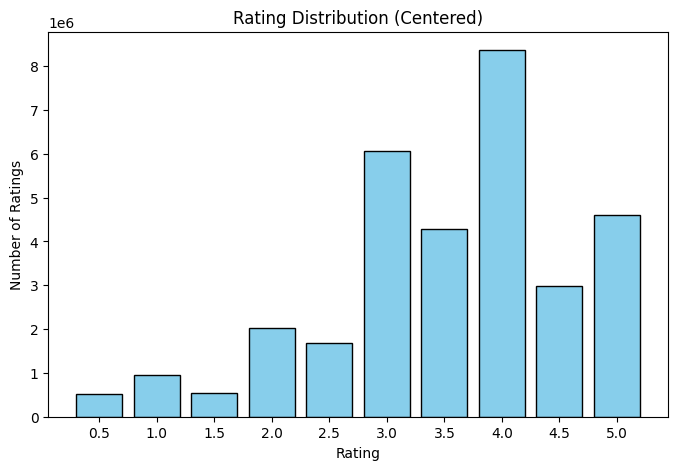

In [8]:
plot_rating_distribution(data)

In [ ]:
def plot_avg_rating_per_user(ratings_data):
    """
    Plots the histogram of average ratings per user.
    """
    user_means = []

    # Calculate means
    for user_ratings in ratings_data.data_by_user:
        if len(user_ratings) > 0:
            ratings = [r for _, r in user_ratings]
            user_means.append(np.mean(ratings))

    global_mean = np.mean(user_means)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(user_means, bins=50, color='teal', edgecolor='black', alpha=0.7)
    plt.axvline(global_mean, color='gold', linestyle='--', linewidth=2, label=f'Mean: {global_mean:.2f}')

    plt.xlabel("Average Rating")
    plt.ylabel("Number of Users")
    plt.title("User Rating Tendencies")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Save
    plt.savefig("user_avg_ratings.pdf", format='pdf', bbox_inches='tight')
    plt.show()

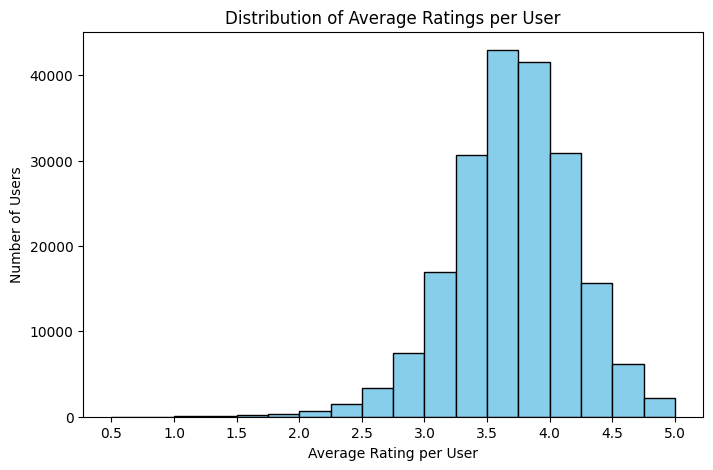

In [10]:
plot_avg_rating_per_user(data)

In [10]:
def plot_frequency_vs_degree(ratings_data):
    """
    Log-Log plot to validate the Power Law (Long Tail) distribution.
    Checks if a small number of items drive the majority of traffic.
    """
    # Calculate degrees
    movie_degrees = np.array([len(r) for r in ratings_data.data_by_movie])
    user_degrees = np.array([len(r) for r in ratings_data.data_by_user])

    # Get frequencies
    movie_deg_x, movie_counts = np.unique(movie_degrees, return_counts=True)
    user_deg_x, user_counts = np.unique(user_degrees, return_counts=True)

    # Plotting
    plt.figure(figsize=(10, 7))

    # Using Crimson and SteelBlue with transparency (alpha) to show point density
    plt.loglog(movie_deg_x, movie_counts, '.', color='crimson', label='Movies', alpha=0.5)
    plt.loglog(user_deg_x, user_counts, '.', color='skyblue', label='Users', alpha=0.5)

    plt.xlabel("Degree (Number of Ratings)")
    plt.ylabel("Frequency")
    plt.title("Interaction Distribution (Log-Log Scale)")
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.legend()

    # Save
    plt.savefig("frequency_vs_degree.pdf", format='pdf', bbox_inches='tight')
    plt.show()

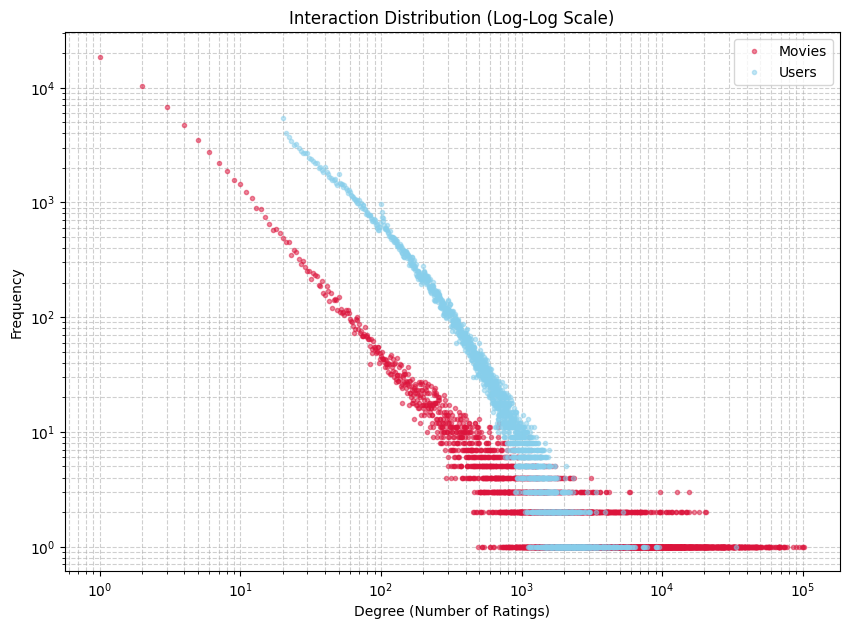

In [11]:
plot_frequency_vs_degree(data)

## Practical 3:

**1. Prediction Formula:**

The predicted rating $\hat{r}_{mn}$ for user $m$ and item $n$:

$$
\hat{r}_{mn} =  \mathbf{u}_m^T \mathbf{v}_n + b_m^u + b_n^i
$$


**2.Negative Log Likelihood (Loss Function):**

$$
L = \frac{\lambda}{2} \sum_{(m,n) \in \Omega} (r_{mn} - \hat{r}_{mn})^2 + \frac{\tau}{2} \left( \sum_{m} ||\mathbf{u}_m||^2 + \sum_{n} ||\mathbf{v}_n||^2 \right) + \frac{\gamma}{2} \left( \sum_{m} (b_m^u)^2 + \sum_{n} (b_n^i)^2 \right)
$$


**3. RMSE:**

The error metric used to evaluate the model.

$$
\text{RMSE} = \sqrt{\frac{1}{|\Omega|} \sum_{(m,n) \in \Omega} (r_{mn} - \hat{r}_{mn})^2}
$$

**4. Alternating Least Squares (ALS):**

* Update User Parameters 


$$
b_m^u \leftarrow \frac{\lambda \sum_{n \in \Omega_m} (r_{mn} - b_n^i - \mathbf{u}_m^T \mathbf{v}_n)}{\lambda |\Omega_m| + \gamma}
$$

$$
\mathbf{u}_m \leftarrow \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n \mathbf{v}_n^T + \tau I \right)^{-1} \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n (r_{mn} - b_m^u - b_n^i) \right)
$$


* Update Item Parameters 


$$
b_n^i \leftarrow \frac{\lambda \sum_{m \in \Omega_n} (r_{mn} - b_m^u - \mathbf{u}_m^T \mathbf{v}_n)}{\lambda |\Omega_n| + \gamma}
$$

$$
\mathbf{v}_n \leftarrow \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m \mathbf{u}_m^T + \tau I \right)^{-1} \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m (r_{mn} - b_m^u - b_n^i) \right)
$$


## Practical 4:

### Train/Test Split Optimization

**Data Splitting & Indexing**

We implemented a 90/10 random split of the MovieLens dataset using a dual-index architecture optimized for Alternating Least Squares (ALS).

**Key Optimizations:**

- Dual-Index Structure: We created both user-sorted and movie-sorted views of the data. This allows for O(1) lookup times, replacing the computationally expensive O(N) iteration required by naive approaches.

- Memory Efficiency: By using cumulative index arrays, we enable direct slicing to retrieve rating groups (e.g., "all movies rated by user m") instantly. We also implemented aggressive garbage collection to free over 1GB of memory.

**Architecture Summary:**

This design supports the specific needs of ALS by providing fast, bidirectional access to training and test data:

- User-Centric Arrays: Sorted by user_idx with start-index pointers.

- Movie-Centric Arrays: Sorted by movie_idx with start-index pointers.


In [12]:
# CONVERT TO NUMPY ARRAYS & TRAIN/TEST SPLIT

n_users = data.num_users()
n_movies = data.num_movies()

# Count total ratings
total_ratings = sum(len(ratings) for ratings in data.data_by_user)
print(f"Total ratings: {total_ratings:,}")

# Pre-allocate array: [user_idx, movie_idx, rating]
print("Creating rating arrays...")
all_ratings = np.zeros((total_ratings, 3), dtype=np.float32)

# Fill the array
idx = 0
for user_idx in range(n_users):
    if user_idx % 10000 == 0 and user_idx > 0:
        print(f"  Processing user {user_idx:,}/{n_users:,}...")

    ratings = data.data_by_user[user_idx]
    for movie_id, rating in ratings:
        movie_idx = data.movie_id_to_idx[movie_id]
        all_ratings[idx] = [user_idx, movie_idx, rating]
        idx += 1

print(f"Array created: {all_ratings.nbytes / 1024**2:.1f} MB")

# Train/Test Split (90/10)

print("\nGenerating train/test split (90/10)...")
np.random.seed(42)
is_train = np.random.rand(total_ratings) < 0.9

# Split into train and test
train_ratings = all_ratings[is_train]
test_ratings = all_ratings[~is_train]

print(f" Train ratings: {len(train_ratings):,} ({len(train_ratings)/total_ratings*100:.1f}%)")
print(f" Test ratings: {len(test_ratings):,} ({len(test_ratings)/total_ratings*100:.1f}%)")
print(f"  Train array: {train_ratings.nbytes / 1024**2:.1f} MB")
print(f"  Test array: {test_ratings.nbytes / 1024**2:.1f} MB")

# SORT AND BUILD FAST ACCESS INDICES
# Sort by user for user-based access
print("Sorting by user...")
train_ratings_by_user = train_ratings[train_ratings[:, 0].argsort()]
test_ratings_by_user = test_ratings[test_ratings[:, 0].argsort()]

# Sort by movie for movie-based access
print("Sorting by movie...")
train_ratings_by_movie = train_ratings[train_ratings[:, 1].argsort()]
test_ratings_by_movie = test_ratings[test_ratings[:, 1].argsort()]

# Build index arrays 
print("Building lookup indices...")
user_train_start = np.zeros(n_users + 1, dtype=np.int32)
user_test_start = np.zeros(n_users + 1, dtype=np.int32)
movie_train_start = np.zeros(n_movies + 1, dtype=np.int32)
movie_test_start = np.zeros(n_movies + 1, dtype=np.int32)

# Build user indices (train)
print("  Indexing users (train)...")
current_user = -1
for i in range(len(train_ratings_by_user)):
    user = int(train_ratings_by_user[i, 0])
    if user != current_user:
        for u in range(current_user + 1, user + 1):
            user_train_start[u] = i
        current_user = user
for u in range(current_user + 1, n_users + 1):
    user_train_start[u] = len(train_ratings_by_user)

# Build user indices (test)
print("  Indexing users (test)...")
current_user = -1
for i in range(len(test_ratings_by_user)):
    user = int(test_ratings_by_user[i, 0])
    if user != current_user:
        for u in range(current_user + 1, user + 1):
            user_test_start[u] = i
        current_user = user
for u in range(current_user + 1, n_users + 1):
    user_test_start[u] = len(test_ratings_by_user)

# Build movie indices (train)
print("  Indexing movies (train)...")
current_movie = -1
for i in range(len(train_ratings_by_movie)):
    movie = int(train_ratings_by_movie[i, 1])
    if movie != current_movie:
        for m in range(current_movie + 1, movie + 1):
            movie_train_start[m] = i
        current_movie = movie
for m in range(current_movie + 1, n_movies + 1):
    movie_train_start[m] = len(train_ratings_by_movie)

# Build movie indices (test)
print("  Indexing movies (test)...")
current_movie = -1
for i in range(len(test_ratings_by_movie)):
    movie = int(test_ratings_by_movie[i, 1])
    if movie != current_movie:
        for m in range(current_movie + 1, movie + 1):
            movie_test_start[m] = i
        current_movie = movie
for m in range(current_movie + 1, n_movies + 1):
    movie_test_start[m] = len(test_ratings_by_movie)

print("Indexing complete!")

# FREE MEMORY

del all_ratings, train_ratings, test_ratings
del data.data_by_user, data.data_by_movie
gc.collect()

print(" Memory freed!")

Total ratings: 32,000,204
Creating rating arrays...
  Processing user 10,000/200,948...
  Processing user 20,000/200,948...
  Processing user 30,000/200,948...
  Processing user 40,000/200,948...
  Processing user 50,000/200,948...
  Processing user 60,000/200,948...
  Processing user 70,000/200,948...
  Processing user 80,000/200,948...
  Processing user 90,000/200,948...
  Processing user 100,000/200,948...
  Processing user 110,000/200,948...
  Processing user 120,000/200,948...
  Processing user 130,000/200,948...
  Processing user 140,000/200,948...
  Processing user 150,000/200,948...
  Processing user 160,000/200,948...
  Processing user 170,000/200,948...
  Processing user 180,000/200,948...
  Processing user 190,000/200,948...
  Processing user 200,000/200,948...
Array created: 366.2 MB

Generating train/test split (90/10)...
 Train ratings: 28,802,949 (90.0%)
 Test ratings: 3,197,255 (10.0%)
  Train array: 329.6 MB
  Test array: 36.6 MB
Sorting by user...
Sorting by movie...


In [13]:
# Functions for fast data access

def get_user_train_ratings(user_idx):
    """
    Get all training ratings for a specific user as [movie_idx, rating]
    """
    start = user_train_start[user_idx]
    end = user_train_start[user_idx + 1]
    # Return columns 1 (movie_idx) and 2 (rating)
    return train_ratings_by_user[start:end, 1:3]

def get_user_test_ratings(user_idx):
    """
    Get all test ratings for a specific user as [movie_idx, rating]
    """
    start = user_test_start[user_idx]
    end = user_test_start[user_idx + 1]
    # Return columns 1 (movie_idx) and 2 (rating)
    return test_ratings_by_user[start:end, 1:3]

def get_movie_train_ratings(movie_idx):
    """
    Get all training ratings for a specific movie as [user_idx, rating]
    """
    start = movie_train_start[movie_idx]
    end = movie_train_start[movie_idx + 1]
    # Return columns 0 (user_idx) and 2 (rating)
    return train_ratings_by_movie[start:end, [0, 2]]

def get_movie_test_ratings(movie_idx):
    """
    Get all test ratings for a specific movie as [user_idx, rating]
    """
    start = movie_test_start[movie_idx]
    end = movie_test_start[movie_idx + 1]
    # Return columns 0 (user_idx) and 2 (rating)
    return test_ratings_by_movie[start:end, [0, 2]]


### Training

In [ ]:
# HYPERPARAMETERS

K = 32               # Number of latent factors
num_iters = 40       # Number of ALS iterations
lambda_reg = 0.001   # Regularization for latent factors (U, V)
tau = 0.05           # Regularization term for user/item vectors
gamma = 0.001        # Regularization for biases

M = n_users          # Number of users
N = n_movies         # Number of movies

print("Initializing the model")
print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# Initialize biases and latent factors

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# Metrics History
nll_history = []
rmse_train_history = []
rmse_test_history = []

# Training Loop
for iter in range(num_iters):

    # Update user parameters
    for m in range(M):
        items = get_user_train_ratings(m)
        if len(items) == 0: continue

        # Update user bias
        bias_sum = 0
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = item_biases[n] + np.dot(U[m], V[n])
            bias_sum += lambda_reg * (r - pred)

        user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

        # Update user latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            residual = r - user_biases[m] - item_biases[n]

            A += lambda_reg * np.outer(V[n], V[n])
            b += lambda_reg * residual * V[n]

        A += tau * np.eye(K, dtype=np.float32)
        U[m] = np.linalg.solve(A, b)

    # Update Item parameters 
    for n in range(N):
        users = get_movie_train_ratings(n)
        if len(users) == 0: continue

        # Update item bias
        bias_sum = 0
        for i in range(len(users)):
            m_idx = int(users[i, 0])  # user_idx
            r = users[i, 1]            # rating
            pred = user_biases[m_idx] + np.dot(U[m_idx], V[n])
            bias_sum += lambda_reg * (r - pred)

        item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

        # Update item latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for i in range(len(users)):
            m_idx = int(users[i, 0])  # user_idx
            r = users[i, 1]            # rating
            residual = r - user_biases[m_idx] - item_biases[n]

            A += lambda_reg * np.outer(U[m_idx], U[m_idx])
            b += lambda_reg * residual * U[m_idx]

        A += tau * np.eye(K, dtype=np.float32)
        V[n] = np.linalg.solve(A, b)

    # Negative log likelihood 
    squared_error = 0
    count = 0

    for m in range(M):
        items = get_user_train_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error += (r - pred) ** 2
            count += 1

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    nll = (lambda_reg / 2) * squared_error + (tau / 2) * reg_factors + (gamma / 2) * reg_bias
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # Test RMSE
    squared_error_test = 0
    count_test = 0

    for m in range(M):
        items = get_user_test_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}: "
          f"Train RMSE = {rmse_train:.4f} | Test RMSE = {rmse_test:.4f} | "
          f"NLL = {nll:.2f}")

# PLOT RESULTS

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(nll_history, marker='o', color='purple')
plt.title("Negative Log Likelihood (Training)")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

: 

### Vectorised Version

In [ ]:
K = 32               # Number of latent factors
num_iters = 15       # Number of ALS iterations
lambda_reg = 0.001
tau = 0.05
gamma = 0.001

M = n_users          # Number of users
N = n_movies         # Number of movies

print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# Initialize biases and latent factors
user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# Metrics history
nll_history = []
rmse_train_history = []
rmse_test_history = []

# Training Loop
import time
for iter in range(num_iters):
    iter_start = time.time()

    # Update user parameters
    for m in range(M):
        items = get_user_train_ratings(m)
        if len(items) == 0: # if user has no ratings
            continue

        # Updated user bias
        movie_indices = items[:, 0].astype(np.int32)  # All movie indices for this user
        ratings = items[:, 1]  # All ratings
        # Vectorized prediction: item_biases[n] + U[m] @ V[n] for all n
        predictions = item_biases[movie_indices] + (U[m] @ V[movie_indices].T)
        residuals = ratings - predictions
        bias_sum = lambda_reg * np.sum(residuals)
        user_biases[m] = bias_sum / (lambda_reg * len(items) + gamma)

        # Update user latent vector
        movie_indices = items[:, 0].astype(np.int32)
        ratings = items[:, 1]
        V_subset = V[movie_indices]  # Shape: (num_items, K)
        residuals = ratings - user_biases[m] - item_biases[movie_indices]  # Shape: (num_items,)

        # Vectorized computation: A = λ Σ V[n] V[n]^T = λ V_subset^T @ V_subset
        A = lambda_reg * (V_subset.T @ V_subset) + tau * np.eye(K, dtype=np.float32)
        # Vectorized computation: b = λ Σ residual[n] * V[n] = λ V_subset^T @ residuals
        b = lambda_reg * (V_subset.T @ residuals)

        U[m] = np.linalg.solve(A, b)

    # Update item parameters
    for n in range(N):
        users = get_movie_train_ratings(n)
        if len(users) == 0:
            continue

        # Update item bias
        user_indices = users[:, 0].astype(np.int32)  # All user indices for this movie
        ratings = users[:, 1]  # All ratings
        # Vectorized prediction: user_biases[m] + U[m] @ V[n] for all m
        predictions = user_biases[user_indices] + (U[user_indices] @ V[n])
        residuals = ratings - predictions
        bias_sum = lambda_reg * np.sum(residuals)
        item_biases[n] = bias_sum / (lambda_reg * len(users) + gamma)

        # Update item latent vector
        user_indices = users[:, 0].astype(np.int32)
        ratings = users[:, 1]
        U_subset = U[user_indices]  # Shape: (num_users, K)
        residuals = ratings - user_biases[user_indices] - item_biases[n]  # Shape: (num_users,)

        # Vectorized computation: A = λ Σ U[m] U[m]^T = λ U_subset^T @ U_subset
        A = lambda_reg * (U_subset.T @ U_subset) + tau * np.eye(K, dtype=np.float32)
        # Vectorized computation: b = λ Σ residual[m] * U[m] = λ U_subset^T @ residuals
        b = lambda_reg * (U_subset.T @ residuals)

        V[n] = np.linalg.solve(A, b)

    # Negative log likelihoood
    squared_error = 0
    count = 0

    for m in range(M):
        items = get_user_train_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error += (r - pred) ** 2
            count += 1

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    nll = (lambda_reg / 2) * squared_error + (tau / 2) * reg_factors + (gamma / 2) * reg_bias
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # Test RMSE
    squared_error_test = 0
    count_test = 0

    for m in range(M):
        items = get_user_test_ratings(m)
        for i in range(len(items)):
            n = int(items[i, 0])  # movie_idx
            r = items[i, 1]        # rating
            pred = user_biases[m] + item_biases[n] + np.dot(U[m], V[n])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    iter_time = time.time() - iter_start

    print(f"Iteration {iter+1}: "
          f"Train RMSE = {rmse_train:.4f} | Test RMSE = {rmse_test:.4f} | "
          f"NLL = {nll:.2f} | Time = {iter_time:.2f}s")

# Plotting
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(nll_history, marker='o', linestyle='-', color='teal', linewidth=2, label='NLL')
plt.title("Negative Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.subplot(1,2,2)
plt.plot(rmse_train_history, marker='o', linestyle='-', color='crimson', linewidth=2, label='Train RMSE')
plt.plot(rmse_test_history, marker='o', linestyle='-', color='steelblue', linewidth=2, label='Test RMSE')
plt.title("RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.tight_layout()

plt.savefig("als_vectorized_results_3.pdf", format='pdf', bbox_inches='tight')

plt.show()

print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

### optimising with numba

In [14]:
# Numba helper functions
@njit
def cholesky_solve(A, b, K):
    """
    Solve Ax = b using Cholesky decomposition (A must be symmetric positive definite).
    This is 2x faster than general LU decomposition for SPD matrices.
    """
    # Cholesky decomposition: A = L @ L.T
    L = np.zeros((K, K), dtype=np.float32)

    for i in range(K):
        for j in range(i + 1):
            s = 0.0
            for k in range(j):
                s += L[i, k] * L[j, k]

            if i == j:
                val = A[i, i] - s
                if val > 0:
                    L[i, j] = np.sqrt(val)
                else:
                    L[i, j] = 1e-6  # Numerical stability
            else:
                if L[j, j] > 0:
                    L[i, j] = (A[i, j] - s) / L[j, j]
                else:
                    L[i, j] = 0.0

    # Forward substitution: L @ y = b
    y = np.zeros(K, dtype=np.float32)
    for i in range(K):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        if L[i, i] > 0:
            y[i] = (b[i] - s) / L[i, i]
        else:
            y[i] = 0.0

    # Backward substitution: L.T @ x = y
    x = np.zeros(K, dtype=np.float32)
    for i in range(K - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, K):
            s += L[j, i] * x[j]  # L.T[i, j] = L[j, i]
        if L[i, i] > 0:
            x[i] = (y[i] - s) / L[i, i]
        else:
            x[i] = 0.0

    return x


@njit(parallel=True)
def update_all_users_numba(
    M, K, lambda_reg, tau, gamma,
    user_biases, item_biases, U, V,
    train_ratings_by_user,
    user_train_start
):
    """
    Update all user biases and latent factors in parallel
    """
    for m in prange(M):
        start = user_train_start[m]
        end = user_train_start[m + 1]
        count = end - start

        if count == 0:
            continue

        # Update user bias
        bias_sum = 0.0
        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]
            pred = item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]
            bias_sum += lambda_reg * (r - pred)

        user_biases[m] = bias_sum / (lambda_reg * count + gamma)

        # Update user latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]
            residual = r - user_biases[m] - item_biases[n]

            for j in range(K):
                b[j] += lambda_reg * residual * V[n, j]
                for k in range(K):
                    A[j, k] += lambda_reg * V[n, j] * V[n, k]

        for j in range(K):
            A[j, j] += tau

        U[m] = cholesky_solve(A, b, K)


@njit(parallel=True)
def update_all_items_numba(
    N, K, lambda_reg, tau, gamma,
    user_biases, item_biases, U, V,
    train_ratings_by_movie,
    movie_train_start
):
    """
    Update all item biases and latent factors in parallel
    """
    for n in prange(N):
        start = movie_train_start[n]
        end = movie_train_start[n + 1]
        count = end - start

        if count == 0:
            continue

        # Update item bias
        bias_sum = 0.0
        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            pred = user_biases[m]
            for k in range(K):
                pred += U[m, k] * V[n, k]
            bias_sum += lambda_reg * (r - pred)

        item_biases[n] = bias_sum / (lambda_reg * count + gamma)

        # Update item latent vector
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            residual = r - user_biases[m] - item_biases[n]

            for j in range(K):
                b[j] += lambda_reg * residual * U[m, j]
                for k in range(K):
                    A[j, k] += lambda_reg * U[m, j] * U[m, k]

        for j in range(K):
            A[j, j] += tau

        V[n] = cholesky_solve(A, b, K)


@njit(parallel=True)
def compute_train_metrics_numba(
    M, K,
    user_biases, item_biases, U, V,
    train_ratings_by_user,
    user_train_start
):
    """
    Compute training squared error and count in parallel
    """
    squared_error = 0.0
    count = 0

    for m in prange(M):
        start = user_train_start[m]
        end = user_train_start[m + 1]

        local_error = 0.0
        local_count = 0

        for idx in range(start, end):
            n = np.int32(train_ratings_by_user[idx, 1])
            r = train_ratings_by_user[idx, 2]

            pred = user_biases[m] + item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]

            local_error += (r - pred) ** 2
            local_count += 1

        squared_error += local_error
        count += local_count

    return squared_error, count


@njit(parallel=True)
def compute_test_rmse_numba(
    M, K,
    user_biases, item_biases, U, V,
    test_ratings_by_user,
    user_test_start
):
    """
    Compute test squared error and count in parallel
    """
    squared_error = 0.0
    count = 0

    for m in prange(M):
        start = user_test_start[m]
        end = user_test_start[m + 1]

        local_error = 0.0
        local_count = 0

        for idx in range(start, end):
            n = np.int32(test_ratings_by_user[idx, 1])
            r = test_ratings_by_user[idx, 2]

            pred = user_biases[m] + item_biases[n]
            for k in range(K):
                pred += U[m, k] * V[n, k]

            local_error += (r - pred) ** 2
            local_count += 1

        squared_error += local_error
        count += local_count

    return squared_error, count


In [18]:
# Optimized Training Loop
# Hyperparameters
K = 32               # Number of latent factors
num_iters = 20       # Number of ALS iterations
lambda_reg = 0.0011  
tau = 0.0403           
gamma = 0.00029        

M = n_users          # Number of users
N = n_movies         # Number of movies

print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")

# INITIALIZE BIASES AND LATENT FACTORS

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors

# Metrics history
nll_history = []
rmse_train_history = []
rmse_test_history = []

# Trining Loop
import time
for iter in range(num_iters):
    iter_start = time.time()

    # Update Users
    update_all_users_numba(
        M, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )

    # Update Items
    update_all_items_numba(
        N, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V,
        train_ratings_by_movie,
        movie_train_start
    )

    # Training metrics
    squared_error, count = compute_train_metrics_numba(
        M, K,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )

    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum(V ** 2)

    # Log likelihood formula from slides
    nll = (lambda_reg / 2) * squared_error + (tau / 2) * reg_factors + (gamma / 2) * reg_bias
    nll_history.append(nll)

    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)

    # Test RMSE
    squared_error_test, count_test = compute_test_rmse_numba(
        M, K,
        user_biases, item_biases, U, V,
        test_ratings_by_user,
        user_test_start
    )

    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)

    iter_time = time.time() - iter_start

    print(f"Iteration {iter+1}: "
          f"Train RMSE = {rmse_train:.4f} | Test RMSE = {rmse_test:.4f} | "
          f"NLL = {nll:.2f} | Time = {iter_time:.2f}s")



Users: 200,948
Movies: 84,432
Latent factors (K): 32
Iterations: 20
λ (lambda_reg): 0.0011
τ (tau): 0.0403
γ (gamma): 0.00029
Iteration 1: Train RMSE = 0.8199 | Test RMSE = 0.8681 | NLL = 11615.07 | Time = 4.67s
Iteration 2: Train RMSE = 0.7188 | Test RMSE = 0.8075 | NLL = 9742.03 | Time = 4.69s
Iteration 3: Train RMSE = 0.6946 | Test RMSE = 0.7883 | NLL = 9352.39 | Time = 4.67s
Iteration 4: Train RMSE = 0.6860 | Test RMSE = 0.7806 | NLL = 9217.54 | Time = 4.56s
Iteration 5: Train RMSE = 0.6817 | Test RMSE = 0.7765 | NLL = 9151.54 | Time = 4.58s
Iteration 6: Train RMSE = 0.6791 | Test RMSE = 0.7740 | NLL = 9113.46 | Time = 4.68s
Iteration 7: Train RMSE = 0.6775 | Test RMSE = 0.7724 | NLL = 9089.10 | Time = 4.64s
Iteration 8: Train RMSE = 0.6764 | Test RMSE = 0.7712 | NLL = 9072.28 | Time = 4.57s
Iteration 9: Train RMSE = 0.6756 | Test RMSE = 0.7703 | NLL = 9059.94 | Time = 4.52s
Iteration 10: Train RMSE = 0.6749 | Test RMSE = 0.7696 | NLL = 9050.45 | Time = 4.61s
Iteration 11: Train RM

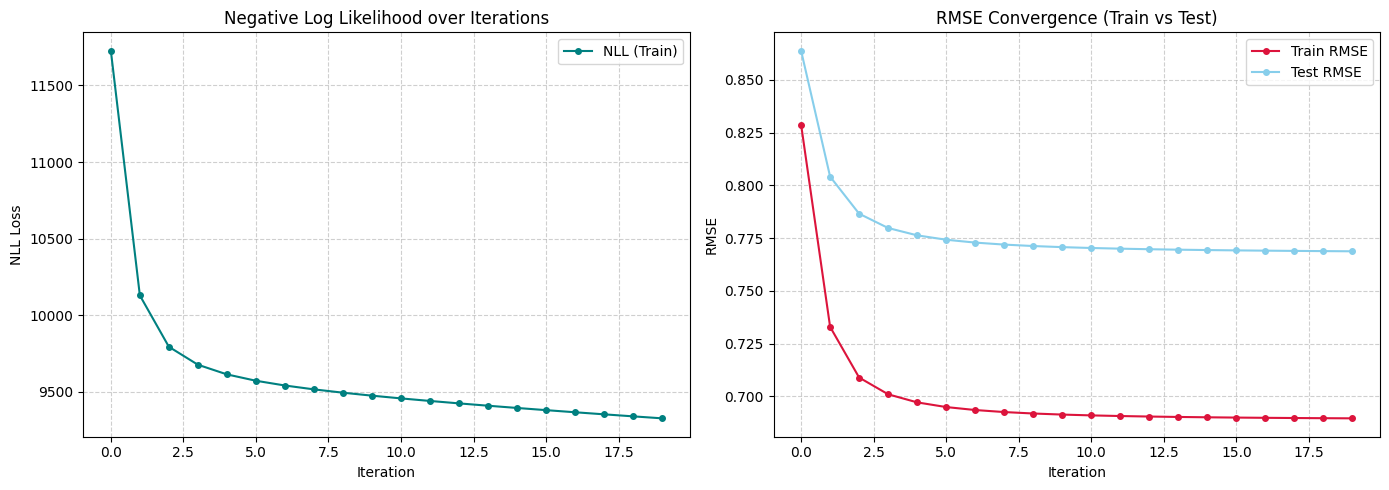

Final Train RMSE: 0.6896
Final Test RMSE: 0.7688


In [17]:
# Plotting 
plt.figure(figsize=(14, 5)) # Adjusted size for better visibility

# Plot NLL
plt.subplot(1, 2, 1) # Changed to 2 columns to use full space
plt.plot(nll_history, marker='o', markersize=4, color='teal', label='NLL (Train)')
plt.title("Negative Log Likelihood over Iterations")
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6) # Added grid for clarity

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(rmse_train_history, marker='o', markersize=4, color='crimson', label='Train RMSE')
plt.plot(rmse_test_history, marker='o', markersize=4, color='skyblue', label='Test RMSE')
plt.title("RMSE Convergence (Train vs Test)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure to the current directory
plt.savefig('optimised_all_latent_factors_convergence_32M.pdf', format='pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

### Hyperparameter Search

In [ ]:
# OBJECTIVE FUNCTION FOR OPTUNA
def objective(trial):
    """
    Optuna objective function to minimize test RMSE.
    Suggests hyperparameters and trains ALS model.
    """
    # SUGGEST HYPERPARAMETERS
    K = 32
    lambda_reg = trial.suggest_float('lambda_reg', 0.0001, 0.01, log=True)
    tau = trial.suggest_float('tau', 0.01, 0.1, log=True)
    gamma = trial.suggest_float('gamma', 0.0001, 0.01, log=True)
    
    # Fixed number of iterations for hyperparameter search
    num_iters = 10  # Reduced for faster search
    
    M = n_users
    N = n_movies
    
    # INITIALIZE BIASES AND LATENT FACTORS
    user_biases = np.zeros(M, dtype=np.float32)
    item_biases = np.zeros(N, dtype=np.float32)
    U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)
    V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)
    
    # ALS TRAINING LOOP
    for iter in range(num_iters):
        # UPDATE ALL USERS (PARALLEL)
        update_all_users_numba(
            M, K, lambda_reg, tau, gamma,
            user_biases, item_biases, U, V,
            train_ratings_by_user,
            user_train_start
        )
        
        # UPDATE ALL ITEMS (PARALLEL)
        update_all_items_numba(
            N, K, lambda_reg, tau, gamma,
            user_biases, item_biases, U, V,
            train_ratings_by_movie,
            movie_train_start
        )
    
    # COMPUTE FINAL TEST RMSE
    squared_error_test, count_test = compute_test_rmse_numba(
        M, K,
        user_biases, item_biases, U, V,
        test_ratings_by_user,
        user_test_start
    )
    
    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else float('inf')
    
    return rmse_test


# RUN HYPERPARAMETER OPTIMIZATION
print("\n" + "="*70)
print("STARTING HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("="*70)

study = optuna.create_study(
    direction='minimize',
    study_name='ALS_Hyperparameter_Search',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# PRINT BEST HYPERPARAMETERS
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOUND")
print("="*70)
print(f"Best Test RMSE: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

In [ ]:
# VISUALIZE OPTIMIZATION


# Optimization History
plot_optimization_history(study)
plt.title("Optimization History")
plt.tight_layout()
plt.savefig("optimization_history.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Hyperparameter Importance
plot_param_importances(study)
plt.tight_layout()
plt.savefig("hyperparameter_importance.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Grid Search for K

In [ ]:
k_values = [2, 4, 8, 16, 32, 64]

try:
    best_params = study.best_params
    lambda_reg = best_params['lambda_reg']
    tau = best_params['tau']
    gamma = best_params['gamma']
    print(f"Using optimal hyperparameters: lambda_reg={lambda_reg:.6f}, tau={tau:.6f}, gamma={gamma:.6f}")
except NameError:
    print("Warning: 'study' object not found. Using default hyperparameters.")
    lambda_reg = 0.001
    tau = 0.05
    gamma = 0.001

num_iters = 15  # Iterations for each K
results_k = {'K': [], 'Test RMSE': [], 'Train RMSE': []}

for K in k_values:
    print(f"\nTraining with K={K}...")
    
    # Initialize Matrices
    M = n_users
    N = n_movies
    user_biases = np.zeros(M, dtype=np.float32)
    item_biases = np.zeros(N, dtype=np.float32)
    U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)
    V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)
    
    # Training Loop
    rmse_train = 0
    for iter in range(num_iters):
        # Update Users
        update_all_users_numba(
            M, K, lambda_reg, tau, gamma,
            user_biases, item_biases, U, V,
            train_ratings_by_user,
            user_train_start
        )
        
        # Update Items
        update_all_items_numba(
            N, K, lambda_reg, tau, gamma,
            user_biases, item_biases, U, V,
            train_ratings_by_movie,
            movie_train_start
        )

        # Compute Train RMSE on final iteration
        if iter == num_iters - 1:
             squared_error, count = compute_train_metrics_numba(
                M, K, user_biases, item_biases, U, V,
                train_ratings_by_user, user_train_start
             )
             rmse_train = np.sqrt(squared_error / count)

    # Compute Test RMSE
    squared_error_test, count_test = compute_test_rmse_numba(
        M, K,
        user_biases, item_biases, U, V,
        test_ratings_by_user,
        user_test_start
    )
    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else float('inf')
    
    print(f"  Result: Test RMSE = {rmse_test:.4f}, Train RMSE = {rmse_train:.4f}")
    
    results_k['K'].append(K)
    results_k['Test RMSE'].append(rmse_test)
    results_k['Train RMSE'].append(rmse_train)

In [ ]:
# Plotting RMSE vs K
plt.figure(figsize=(10, 6))
plt.plot(results_k['K'], results_k['Test RMSE'], marker='o', linewidth=2, label='Test RMSE', color='blue')
plt.plot(results_k['K'], results_k['Train RMSE'], marker='s', linewidth=2, linestyle='--', label='Train RMSE', color='orange')

plt.xscale('log', base=2)
plt.xticks(k_values, k_values)  # Show actual K values on axis
plt.xlabel('Number of Latent Factors (K) - Log Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Impact of Latent Factors (K) on Model Performance', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)

plt.tight_layout()
plt.show()

### Test with dummy user

In [19]:
# helper function for movie name from movie_id


movies = pd.read_csv("ml-32m/movies.csv")

def get_movie_name(movie_id):
    row = movies[movies["movieId"] == movie_id]
    return row.iloc[0]["title"]

In [20]:
# DUMMY USER SETUP
try_movie_id = 1
rating_value = 5.0

# Get the movie index

try_movie_idx = data.movie_id_to_idx[try_movie_id]
print(f"Movie ID: {try_movie_id}")
print(f"Movie Index: {try_movie_idx}")
print(f"Rating: {rating_value}")

# Dummy user's ratings: [(movie_idx, rating)]
dummy_user_ratings = [(try_movie_idx, rating_value)]

# Training 
# Initialize dummy user's parameters
dummy_user_bias = 0.0
dummy_user_latent = np.zeros(K, dtype=np.float32)

dummy_iters = 3

for iter in range(dummy_iters):
    # Update dummy user bias
    bias_sum = 0
    for movie_idx, rating in dummy_user_ratings:
        pred = item_biases[movie_idx] + np.dot(dummy_user_latent, V[movie_idx])
        residual = rating - pred
        bias_sum += lambda_reg * residual

    dummy_user_bias = bias_sum / (lambda_reg * len(dummy_user_ratings) + gamma)

    # Update dummy user latent vector
    A = np.zeros((K, K), dtype=np.float32)
    b = np.zeros(K, dtype=np.float32)

    for movie_idx, rating in dummy_user_ratings:
        residual = rating - dummy_user_bias - item_biases[movie_idx]

        A += lambda_reg * np.outer(V[movie_idx], V[movie_idx])
        b += lambda_reg * residual * V[movie_idx]

    A += tau * np.eye(K, dtype=np.float32)
    dummy_user_latent = np.linalg.solve(A, b)

    print(f"Iteration {iter+1}: bias = {dummy_user_bias:.4f}")

print(" Dummy user trained!")

Movie ID: 1
Movie Index: 0
Rating: 5.0
Iteration 1: bias = 3.7070
Iteration 2: bias = 3.2098
Iteration 3: bias = 2.9568
 Dummy user trained!


In [ ]:
# Compute scores for all movies
scores = np.zeros(N, dtype=np.float32)

for n in range(N):
    scores[n] = np.dot(dummy_user_latent, V[n]) + 0.05 * item_biases[n]

# FILTER OUT LOW-RATED MOVIES

print("Filtering movies with fewer than 100 ratings...")

# Count ratings per movie in training set
movie_rating_counts = np.zeros(N, dtype=np.int32)
for n in range(N):
    movie_rating_counts[n] = movie_train_start[n+1] - movie_train_start[n]

# Create mask for movies with >= 100 ratings
popular_movies_mask = movie_rating_counts >= 100
num_popular = np.sum(popular_movies_mask)

print(f"Movies with >= 100 ratings: {num_popular:,}/{N:,}")

# Set scores of unpopular movies to (-inf) so they don't appear in recommendations
filtered_scores = scores.copy()
filtered_scores[~popular_movies_mask] = -np.inf

# GET TOP RECOMMENDATIONS

print("Top 10 Rcommendations")

# Get top 10 movie indices
filtered_scores[try_movie_idx] = -np.inf  # To not recommend the rated movie

top_indices = np.argsort(filtered_scores)[::-1][:10]

print(f"\n{'Rank':<6} {'Movie ID':<12} {'  Title':<12}")
print("-" * 50)

for rank, movie_idx in enumerate(top_indices, 1):
    movie_id = data.idx_to_movie_id[movie_idx]
    movie_name = get_movie_name(movie_id)
    print(f"{rank:<6} {movie_id:<12} {movie_name:}")


COMPUTING RECOMMENDATION SCORES
Filtering movies with fewer than 100 ratings...
Movies with >= 100 ratings: 11,732/84,432

TOP 20 RECOMMENDATIONS

Rank   Movie ID     # Movie Title
--------------------------------------------------
1      3114         Toy Story 2 (1999)
2      4886         Monsters, Inc. (2001)
3      6377         Finding Nemo (2003)
4      8961         Incredibles, The (2004)
5      78499        Toy Story 3 (2010)
6      4306         Shrek (2001)
7      2355         Bug's Life, A (1998)
8      480          Jurassic Park (1993)
9      588          Aladdin (1992)
10     364          Lion King, The (1994)
11     68954        Up (2009)
12     2028         Saving Private Ryan (1998)
13     150          Apollo 13 (1995)
14     8360         Shrek 2 (2004)
15     34           Babe (1995)
16     50872        Ratatouille (2007)
17     134853       Inside Out (2015)
18     60069        WALL·E (2008)
19     2959         Fight Club (1999)
20     3751         Chicken Run (2000)


### Polarizing Movies

In [21]:
# Count ratings per movie
movie_rating_counts = np.zeros(N, dtype=int)
for movie_idx in range(N):
    start = movie_train_start[movie_idx]
    end = movie_train_start[movie_idx + 1]
    movie_rating_counts[movie_idx] = end - start

# Helper
def has_enough_ratings(movie_idx, min_ratings=20):
    return movie_rating_counts[movie_idx] >= min_ratings

# Norms
movie_norms = np.linalg.norm(V, axis=1)
sorted_desc = np.argsort(-movie_norms)   # descending
top_10 = []

for movie_idx in sorted_desc:
    if has_enough_ratings(movie_idx):
        movie_id = data.idx_to_movie_id[movie_idx]
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        top_10.append((title, movie_id, movie_norms[movie_idx]))
        if len(top_10) == 10:
            break

print("\n=== TOP 10 MOST POLARIZING MOVIES ===")
for title, movie_id, norm in top_10:
    print(f"{title:60s} | ID={movie_id:6d} | norm={norm:.4f}")

sorted_asc = np.argsort(movie_norms)   # ascending
bottom_10 = []

for movie_idx in sorted_asc:
    if has_enough_ratings(movie_idx):
        movie_id = data.idx_to_movie_id[movie_idx]
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        bottom_10.append((title, movie_id, movie_norms[movie_idx]))
        if len(bottom_10) == 10:
            break



=== TOP 10 MOST POLARIZING MOVIES ===
Lord of the Rings: The Fellowship of the Ring, The (2001)    | ID=  4993 | norm=10.9289
Lord of the Rings: The Return of the King, The (2003)        | ID=  7153 | norm=10.8518
Lord of the Rings: The Two Towers, The (2002)                | ID=  5952 | norm=10.7209
Star Wars: Episode IV - A New Hope (1977)                    | ID=   260 | norm=10.6544
Forrest Gump (1994)                                          | ID=   356 | norm=10.5982
Pulp Fiction (1994)                                          | ID=   296 | norm=10.5221
Star Wars: Episode V - The Empire Strikes Back (1980)        | ID=  1196 | norm=9.9231
Matrix, The (1999)                                           | ID=  2571 | norm=9.7761
Star Wars: Episode VI - Return of the Jedi (1983)            | ID=  1210 | norm=9.5833
Ace Ventura: Pet Detective (1994)                            | ID=   344 | norm=9.5418


In [25]:
# Sort movies by number of ratings (descending)
sorted_by_count = np.argsort(-movie_rating_counts)

top_10_most_rated = []

for movie_idx in sorted_by_count[:10]:
    movie_id = data.idx_to_movie_id[movie_idx]
    title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
    count = movie_rating_counts[movie_idx]
    top_10_most_rated.append((title, movie_id, count))

print("\n=== TOP 10 MOST RATED MOVIES ===")
for title, movie_id, count in top_10_most_rated:
    print(f"{title:60s} | ID={movie_id:6d} | ratings={count}")



=== TOP 10 MOST RATED MOVIES ===
Shawshank Redemption, The (1994)                             | ID=   318 | ratings=92669
Forrest Gump (1994)                                          | ID=   356 | ratings=90342
Pulp Fiction (1994)                                          | ID=   296 | ratings=88520
Matrix, The (1999)                                           | ID=  2571 | ratings=84376
Silence of the Lambs, The (1991)                             | ID=   593 | ratings=81310
Star Wars: Episode IV - A New Hope (1977)                    | ID=   260 | ratings=76435
Fight Club (1999)                                            | ID=  2959 | ratings=69584
Jurassic Park (1993)                                         | ID=   480 | ratings=67883
Schindler's List (1993)                                      | ID=   527 | ratings=66532
Lord of the Rings: The Fellowship of the Ring, The (2001)    | ID=  4993 | ratings=65817


In [ ]:
movie_id = 356
movie_idx = data.movie_id_to_idx[movie_id]
norm_144436 = movie_norms[movie_idx]
print("Norm for movieId 144436:", norm_144436)

In [ ]:
title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
print(f"{title} (movieId={movie_id}) has norm = {norm_144436:.6f}")

### 2D Vector Embeddings

In [ ]:
from sklearn.decomposition import PCA

# Ensure inline plotting
%matplotlib inline

def plot_movie_embeddings_pca(movie_ids, movies_latent, movies_biases, movie_to_idx, movies_df):
    """
    Reduces latent dimensions to 2D using PCA and plots movie embeddings.
    Features: White background and dynamic resizing to fit labels.
    """
    
    # 1. Force white background
    plt.style.use('default')

    # PCA on Latent Matrix
    pca = PCA(n_components=2)
    V_2d = pca.fit_transform(movies_latent)   # shape (n_movies, 2)

    # Extract embeddings for selected movies
    x_vals = []
    y_vals = []
    titles = []

    for movie_id in movie_ids:
        # Safety check: ensure movie is in our trained model
        if movie_id in movie_to_idx:
            idx = movie_to_idx[movie_id]
            x_vals.append(V_2d[idx, 0])
            y_vals.append(V_2d[idx, 1])
            # Get title safely
            titles.append(movies_df.loc[movies_df["movieId"] == movie_id, "title"].iloc[0])

    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    # Get biases for scaling point size
    selected_biases = np.array([movies_biases[movie_to_idx[m]] for m in movie_ids if m in movie_to_idx])
    scale = 1 + 0.05 * selected_biases  # small bias-based scaling

    # Plotting
    plt.figure(figsize=(16, 10)) # Adjusted size for better report fit

    for i, title in enumerate(titles):
        plt.scatter(x_vals[i], y_vals[i], s=120 * scale[i], alpha=0.8, edgecolors='white')
        # Add text with slight offset
        plt.text(x_vals[i] + 0.02, y_vals[i] + 0.02, title, fontsize=10)

    # 2. Dynamic Resizing: Expand limits so labels aren't cut off
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    
    # Add 15% margin to the right/top/bottom/left
    x_margin = (x_max - x_min) * 0.15
    y_margin = (y_max - y_min) * 0.15
    
    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)

    plt.title("Movie Embeddings (PCA Reduction to 2D)", fontsize=16)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    
    # Add subtle grid
    plt.grid(True, linestyle=':', alpha=0.6, color='gray')
    plt.tight_layout()

    plt.savefig("movie_embeddings_pca.pdf", format="pdf", bbox_inches='tight')
    plt.show()

# List of movies to visualize
movie_ids = [78772, 72407, 1, 78499, 3114, 91104, 98203, 8957, 39446, 48877, 55577]

# Run the function
plot_movie_embeddings_pca(
    movie_ids,
    V,
    item_biases,
    data.movie_id_to_idx,
    movies
)

Plotting separation for: ['Children', 'Horror', 'Drama']


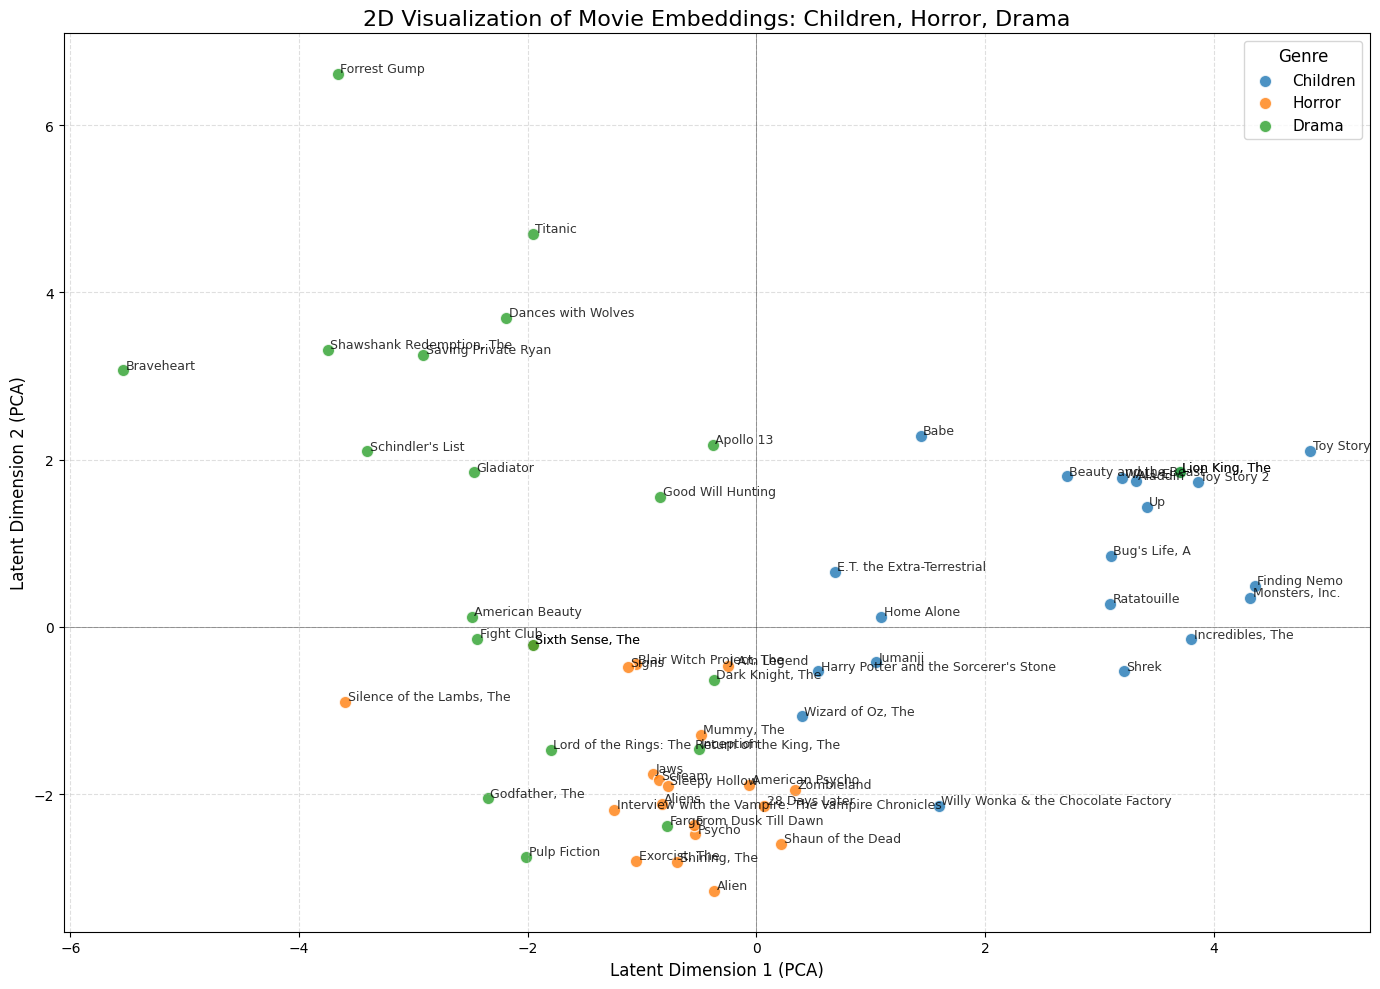

In [23]:

def plot_genre_separation(genre_list=['Children', 'Horror', 'Documentary']):
    """
    Visualizes movie embeddings for specific genres to show semantic separation.
    Uses PCA to reduce dimensions to 2D.
    """
    print(f"Plotting separation for: {genre_list}")
    
    # 1. Setup: Calculate popularity (rating counts) for all movies
    # We only want to plot popular movies so the chart is readable
    movie_counts = np.zeros(n_movies)
    for m in range(n_movies):
        movie_counts[m] = movie_train_start[m+1] - movie_train_start[m]
        
    # Lists to store the final data for plotting
    all_indices = []
    all_labels = []
    all_titles = []
    
    # 2. Select Movies for each Genre
    for genre in genre_list:
        # Filter movies dataframe for this genre
        genre_mask = movies['genres'].str.contains(genre, na=False)
        genre_movies_df = movies[genre_mask]
        
        candidates = []
        
        for movie_id in genre_movies_df['movieId']:
            # Check if movie exists in our trained model
            if movie_id in data.movie_id_to_idx:
                idx = data.movie_id_to_idx[movie_id]
                count = movie_counts[idx]
                
                # FILTER: Only keep movies with > 500 ratings (Adjust as needed)
                if count > 500: 
                    candidates.append((idx, count, movie_id))
        
        # Sort by popularity and take top 20 movies per genre (prevents overcrowding)
        candidates.sort(key=lambda x: x[1], reverse=True)
        top_candidates = candidates[:20]
        
        for idx, count, m_id in top_candidates:
            all_indices.append(idx)
            all_labels.append(genre)
            
            # Get title and clean it (remove year for cleaner plot)
            raw_title = movies.loc[movies['movieId'] == m_id, 'title'].values[0]
            clean_title = raw_title.split('(')[0].strip()
            all_titles.append(clean_title)

    # 3. Extract Vectors and Run PCA
    # We run PCA *only* on these selected movies to maximize the visual separation
    selected_vectors = V[all_indices]
    
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(selected_vectors)
    
    # 4. Plotting
    plt.figure(figsize=(14, 10))
    
    # Define distinct colors for the genres
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Blue, Orange, Green, Red
    
    # Plot each genre separately to create the legend
    unique_labels = list(set(all_labels))
    # Ensure order matches input genre_list if possible
    sorted_labels = [g for g in genre_list if g in unique_labels]
    
    for i, genre in enumerate(sorted_labels):
        # Find indices corresponding to this genre
        indices = [k for k, x in enumerate(all_labels) if x == genre]
        
        # Get the X and Y coordinates for these movies
        genre_x = vectors_2d[indices, 0]
        genre_y = vectors_2d[indices, 1]
        
        # Plot points
        plt.scatter(genre_x, genre_y, label=genre, alpha=0.8, s=80, 
                    color=colors[i % len(colors)], edgecolors='white')
        
        # Add titles (Annotations)
        for j, idx_in_subset in enumerate(indices):
            plt.text(vectors_2d[idx_in_subset, 0] + 0.02, 
                     vectors_2d[idx_in_subset, 1] + 0.02, 
                     all_titles[idx_in_subset], 
                     fontsize=9, alpha=0.8)

    # Styling
    plt.title(f"2D Visualization of Movie Embeddings: {', '.join(genre_list)}", fontsize=16)
    plt.xlabel("Latent Dimension 1 (PCA)", fontsize=12)
    plt.ylabel("Latent Dimension 2 (PCA)", fontsize=12)
    plt.legend(title="Genre", fontsize=11, title_fontsize=12, loc='best')
    plt.grid(True, linestyle='--', alpha=0.4)
    
    # Add axes lines at 0,0
    plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    plt.axvline(0, color='black', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig("genre_separation_pca.pdf", format='pdf', bbox_inches='tight')
    plt.show()

# Run the function
# You can change the genres list to whatever you want (e.g., ['Action', 'Romance', 'Sci-Fi'])
plot_genre_separation(['Children', 'Horror', 'Drama'])

# Genre MetaData Integration

### Genre Loading Functions

In [24]:
def load_genre_data(movies_csv_path, movie_id_to_idx):
    """
    Load genre information from movies.csv
    
    Returns:
    genre_to_idx : dict
        Maps genre name (str) -> genre index (int)
    idx_to_genre : list
        Maps genre index -> genre name
    movie_to_genres : list of lists
        movie_to_genres[movie_idx] = [genre_idx1, genre_idx2, ...]
    """
 
    genre_to_idx = {}
    idx_to_genre = []
    movie_to_genres = [[] for _ in range(len(movie_id_to_idx))]
    
    with open(movies_csv_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        
        movies_processed = 0
        movies_with_genres = 0
        
        for row in reader:
            if len(row) < 3:
                continue
                
            movie_id = int(row[0])
            # Last column contains genres like "Adventure|Animation|Children"
            genres_str = row[-1]
            
            # Skip movies not in our ratings dataset
            if movie_id not in movie_id_to_idx:
                continue
            
            movies_processed += 1
            movie_idx = movie_id_to_idx[movie_id]
            
            # Parse genres
            if genres_str and genres_str != "(no genres listed)":
                genres = genres_str.split('|')
                movies_with_genres += 1
                
                for genre in genres:
                    genre = genre.strip()
                    
                    # Add new genre to mapping
                    if genre not in genre_to_idx:
                        genre_idx = len(genre_to_idx)
                        genre_to_idx[genre] = genre_idx
                        idx_to_genre.append(genre)
                    else:
                        genre_idx = genre_to_idx[genre]
                    
                    movie_to_genres[movie_idx].append(genre_idx)
    
    print(f" Processed {movies_processed:,} movies")
    print(f" Movies with genres: {movies_with_genres:,}")
    print(f" Unique genres: {len(genre_to_idx)}")
    print(f" Average genres per movie: {np.mean([len(g) for g in movie_to_genres if g]):.2f}")
    
    # Print all genres found
    print("\nGenres found:")
    for idx, genre in enumerate(idx_to_genre):
        count = sum(1 for genres in movie_to_genres if idx in genres)
        print(f"  {idx:2d}. {genre:20s} ({count:,} movies)")
    
    return genre_to_idx, idx_to_genre, movie_to_genres


def build_genre_to_movies(movie_to_genres, n_genres):
    """
    Build reverse mapping: genre_idx -> list of movie_idx that have this genre
    
    Returns:
    --------
    genre_to_movies : list of numpy arrays
        genre_to_movies[genre_idx] = np.array([movie_idx1, movie_idx2, ...])
    """
    print("\nBuilding genre-to-movies mapping...")
    
    # First pass: count movies per genre
    genre_counts = [0] * n_genres
    for movie_idx, genres in enumerate(movie_to_genres):
        for genre_idx in genres:
            genre_counts[genre_idx] += 1
    
    # Second pass: allocate and fill arrays
    genre_to_movies = [np.zeros(count, dtype=np.int32) for count in genre_counts]
    genre_positions = [0] * n_genres
    
    for movie_idx, genres in enumerate(movie_to_genres):
        for genre_idx in genres:
            pos = genre_positions[genre_idx]
            genre_to_movies[genre_idx][pos] = movie_idx
            genre_positions[genre_idx] += 1
    
    print("✓ Genre-to-movies mapping built")
    return genre_to_movies


def prepare_genre_data_for_numba(movie_to_genres, genre_to_movies, N, G):
    """
    Convert Python lists to flat numpy arrays that Numba can use efficiently.
    
    Returns:
    --------
    movie_to_genres_flat : np.array (int32)
        All genre indices concatenated
    movie_genre_start : np.array (int32, size N+1)
        movie_genre_start[n] = start index in movie_to_genres_flat for movie n
    genre_to_movies_flat : np.array (int32)
        All movie indices concatenated
    genre_movie_start : np.array (int32, size G+1)
        genre_movie_start[f] = start index in genre_to_movies_flat for genre f
    """
    print("\nPreparing genre data for Numba...")
    
    # Flatten movie -> genres
    movie_to_genres_flat = []
    movie_genre_start = np.zeros(N + 1, dtype=np.int32)
    
    for n in range(N):
        movie_genre_start[n] = len(movie_to_genres_flat)
        movie_to_genres_flat.extend(movie_to_genres[n])
    movie_genre_start[N] = len(movie_to_genres_flat)
    
    movie_to_genres_flat = np.array(movie_to_genres_flat, dtype=np.int32)
    
    # Flatten genre -> movies
    genre_to_movies_flat = []
    genre_movie_start = np.zeros(G + 1, dtype=np.int32)
    
    for f in range(G):
        genre_movie_start[f] = len(genre_to_movies_flat)
        genre_to_movies_flat.extend(genre_to_movies[f])
    genre_movie_start[G] = len(genre_to_movies_flat)
    
    genre_to_movies_flat = np.array(genre_to_movies_flat, dtype=np.int32)
    
    print(f"✓ Movie-to-genres array: {len(movie_to_genres_flat):,} entries")
    print(f"✓ Genre-to-movies array: {len(genre_to_movies_flat):,} entries")
    
    return movie_to_genres_flat, movie_genre_start, genre_to_movies_flat, genre_movie_start

In [ ]:
# Load genre information
genre_to_idx, idx_to_genre, movie_to_genres = load_genre_data(
    "ml-32m/movies.csv", 
    data.movie_id_to_idx
)

# Build reverse mapping
genre_to_movies = build_genre_to_movies(
    movie_to_genres, 
    len(genre_to_idx)
)

# Prepare genre data structures for Numba
movie_to_genres_flat, movie_genre_start, \
genre_to_movies_flat, genre_movie_start = \
    prepare_genre_data_for_numba(
        movie_to_genres,
        genre_to_movies,
        n_movies,
        len(genre_to_idx)
    )

# Store genre count for later use
n_genres = len(genre_to_idx)

print("\n Ready for genre-integrated training!")
print(f"  Genres: {n_genres}")
print(f"  Movies: {n_movies}")
print(f"  Users: {n_users}")


### Genre-Integrated ALS with Numba

In [ ]:
# Helpper functions 
# compute_train_metrics_numba
# compute_test_rmse_numba 
# cholesky_solve 
# update_all_users_numba 

@njit

# new: compute_movie_priors_numba
@njit(parallel=True)
def compute_movie_priors_numba(N, K, movie_to_genres_flat, movie_genre_start, W, V_prior):
    """
    Compute prior for each movie: average of its genre embeddings
    
    Parameters:
    -----------
    N : int
        Number of movies
    K : int
        Latent dimension
    movie_to_genres_flat : np.array (int32)
        Flattened array of all genre indices for all movies
    movie_genre_start : np.array (int32)
        Index array: movie n's genres are in movie_to_genres_flat[start[n]:start[n+1]]
    W : np.array (float32, shape G x K)
        Genre embeddings
    V_prior : np.array (float32, shape N x K) [OUTPUT]
        Will be filled with movie priors
    """
    for n in prange(N):
        start = movie_genre_start[n]
        end = movie_genre_start[n + 1]
        n_genres = end - start
        
        if n_genres == 0:
            # No genres: prior is zero
            for k in range(K):
                V_prior[n, k] = 0.0
        else:
            # Prior = average of genre embeddings
            for k in range(K):
                sum_val = 0.0
                for idx in range(start, end):
                    genre_idx = movie_to_genres_flat[idx]
                    sum_val += W[genre_idx, k]
                V_prior[n, k] = sum_val / n_genres


# modified: update_all_items_with_genres_numba 
@njit(parallel=True)
def update_all_items_with_genres_numba(
    N, K, lambda_reg, tau, gamma,
    user_biases, item_biases, U, V, V_prior,
    train_ratings_by_movie,
    movie_train_start
):
    """
    Update all item biases and latent factors with genre regularization.
    
    KEY CHANGE: Instead of regularizing V[n] toward 0, we regularize toward V_prior[n]
    """
    for n in prange(N):
        start = movie_train_start[n]
        end = movie_train_start[n + 1]
        count = end - start

        if count == 0:
            # No ratings: set V[n] = V_prior[n]
            for k in range(K):
                V[n, k] = V_prior[n, k]
            continue

        # Update item bias
        bias_sum = 0.0
        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            pred = user_biases[m]
            for k in range(K):
                pred += U[m, k] * V[n, k]
            bias_sum += lambda_reg * (r - pred)

        item_biases[n] = bias_sum / (lambda_reg * count + gamma)

        # Update item latent vector (WITH GENRE PRIOR)
        A = np.zeros((K, K), dtype=np.float32)
        b = np.zeros(K, dtype=np.float32)

        for idx in range(start, end):
            m = np.int32(train_ratings_by_movie[idx, 0])
            r = train_ratings_by_movie[idx, 2]
            residual = r - user_biases[m] - item_biases[n]

            for j in range(K):
                b[j] += lambda_reg * residual * U[m, j]
                for k in range(K):
                    A[j, k] += lambda_reg * U[m, j] * U[m, k]

        # Add regularization: tau * I for A, and tau * V_prior[n] for b
        for j in range(K):
            A[j, j] += tau
            b[j] += tau * V_prior[n, j]  # <-- KEY ADDITION

        V[n] = cholesky_solve(A, b, K)


# new: update_all_genres_numba
@njit(parallel=True)
def update_all_genres_numba(G, K, tau, eta, W, V, genre_to_movies_flat, genre_movie_start):
    """
    Update genre embeddings.
    
    For each genre f:
    W[f] = (tau * sum_{n in M(f)} V[n]) / (tau * |M(f)| + eta)
    
    This is a weighted average of all movie embeddings that have this genre.
    """
    for f in prange(G):
        start = genre_movie_start[f]
        end = genre_movie_start[f + 1]
        n_movies = end - start
        
        if n_movies == 0:
            # No movies with this genre: set to zero
            for k in range(K):
                W[f, k] = 0.0
            continue
        
        # W[f] = weighted average of movie embeddings
        denominator = tau * n_movies + eta
        
        for k in range(K):
            numerator = 0.0
            for idx in range(start, end):
                movie_idx = genre_to_movies_flat[idx]
                numerator += tau * V[movie_idx, k]
            
            W[f, k] = numerator / denominator

In [28]:
# HYPERPARAMETERS
K = 32               # Number of latent factors
num_iters = 25       # Number of ALS iterations
eta = 0.01           # Regularization for genre embeddings

lambda_reg = 0.0019978
tau = 0.066778
gamma = 0.0002675


M = n_users          # Number of users
N = n_movies         # Number of movies
G = n_genres         # NEW: Number of genres

print(f"Users: {M:,}")
print(f"Movies: {N:,}")
print(f"Genres: {G}")
print(f"Latent factors (K): {K}")
print(f"Iterations: {num_iters}")
print(f"λ (lambda_reg): {lambda_reg}")
print(f"τ (tau): {tau}")
print(f"γ (gamma): {gamma}")
print(f"η (eta): {eta}")

# Initialize Biases and Latent Factors

user_biases = np.zeros(M, dtype=np.float32)
item_biases = np.zeros(N, dtype=np.float32)
U = ((1/math.sqrt(K)) * np.random.randn(M, K)).astype(np.float32)   # User latent factors
V = ((1/math.sqrt(K)) * np.random.randn(N, K)).astype(np.float32)   # Item latent factors
W = ((1/math.sqrt(K)) * np.random.randn(G, K)).astype(np.float32)   # NEW: Genre embeddings

# Preallocate prior array
V_prior = np.zeros((N, K), dtype=np.float32)

# For plotting
nll_history = []
rmse_train_history = []
rmse_test_history = []

# Training Loop
import time
for iter in range(num_iters):
    iter_start = time.time()
    
    # Compute movie priors
    compute_movie_priors_numba(
        N, K,
        movie_to_genres_flat,
        movie_genre_start,
        W,
        V_prior
    )
    
    # Update all users 
    update_all_users_numba(
        M, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )
    
    # Update all items
    update_all_items_with_genres_numba(
        N, K, lambda_reg, tau, gamma,
        user_biases, item_biases, U, V, V_prior,
        train_ratings_by_movie,
        movie_train_start
    )
    
    # Update all genres
    update_all_genres_numba(
        G, K, tau, eta,
        W, V,
        genre_to_movies_flat,
        genre_movie_start
    )
    
    # Training metrics
    squared_error, count = compute_train_metrics_numba(
        M, K,
        user_biases, item_biases, U, V,
        train_ratings_by_user,
        user_train_start
    )
    
    # Regularization terms
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    reg_factors = np.sum(U ** 2) + np.sum((V - V_prior) ** 2)  # Modified: V regularized toward prior
    reg_genres = np.sum(W ** 2)  
    
    # Log likelihood formula (with genre term)
    nll = (
        (lambda_reg / 2) * squared_error 
        + (tau / 2) * reg_factors 
        + (gamma / 2) * reg_bias
        + (eta / 2) * reg_genres  
    )
    nll_history.append(nll)
    
    # Training RMSE
    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)
    
    # Test RMSE
    squared_error_test, count_test = compute_test_rmse_numba(
        M, K,
        user_biases, item_biases, U, V,
        test_ratings_by_user,
        user_test_start
    )
    
    rmse_test = np.sqrt(squared_error_test / count_test) if count_test > 0 else 0
    rmse_test_history.append(rmse_test)
    
    iter_time = time.time() - iter_start
    
    print(f"Iteration {iter+1}: "
          f"Train RMSE = {rmse_train:.4f} | Test RMSE = {rmse_test:.4f} | "
          f"NLL = {nll:.2f} | Time = {iter_time:.2f}s")

print(f"Final Train RMSE: {rmse_train_history[-1]:.4f}")
print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")

NameError: name 'n_genres' is not defined

In [ ]:
# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(nll_history, marker='o', markersize=4, color='purple', label='NLL (Train)')
plt.title("Negative Log Likelihood over Iterations (With Genres)")
plt.xlabel("Iteration")
plt.ylabel("NLL Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(rmse_train_history, marker='o', markersize=4, color='orange', label='Train RMSE')
plt.plot(rmse_test_history, marker='o', markersize=4, color='blue', label='Test RMSE')
plt.title("RMSE Convergence (Train vs Test, With Genres)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Genre Embedding Visualization (K=2 only)

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

def plot_genre_embeddings_2d(W, idx_to_genre, save_path=None):
    """
    Plot 2D genre embeddings 
    works when K = 2 
    """
    if W.shape[1] != 2:
        print(f"ERROR: Cannot plot {W.shape[1]}D embeddings in 2D!")
        print("Set K=2 to visualize genre embeddings.")
        return
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot each genre as a point
    for genre_idx, genre_name in enumerate(idx_to_genre):
        x, y = W[genre_idx]
        ax.scatter(x, y, s=150, alpha=0.7)
        ax.annotate(genre_name, (x, y), fontsize=11, fontweight='bold',
                   xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlabel('Latent Dimension 1', fontsize=13, fontweight='bold')
    ax.set_ylabel('Latent Dimension 2', fontsize=13, fontweight='bold')
    ax.set_title('Genre Embeddings (2D) - Learned from MovieLens Data', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Saved genre embedding plot to {save_path}")
    
    plt.show()
    
    # Print genre distances for analysis
    distances = euclidean_distances(W)
    
    print("\nMost similar genre pairs (closest in embedding space):")
    pairs = []
    for i in range(len(W)):
        for j in range(i+1, len(W)):
            pairs.append((idx_to_genre[i], idx_to_genre[j], distances[i, j]))
    
    pairs.sort(key=lambda x: x[2])
    for g1, g2, dist in pairs[:10]:
        print(f"  {g1:20s} <-> {g2:20s} : {dist:.3f}")
    
    print("\nMost dissimilar genre pairs (furthest in embedding space):")
    for g1, g2, dist in pairs[-10:]:
        print(f"  {g1:20s} <-> {g2:20s} : {dist:.3f}")


"""
if K == 2:
    plot_genre_embeddings_2d(W, idx_to_genre, save_path='genre_embeddings_2d.pdf')
else:
    print(f"K={K}. Set K=2 to visualize genre embeddings in 2D.")
"""

'\nif K == 2:\n    plot_genre_embeddings_2d(W, idx_to_genre, save_path=\'genre_embeddings_2d.pdf\')\nelse:\n    print(f"K={K}. Set K=2 to visualize genre embeddings in 2D.")\n'

In [ ]:
plot_genre_embeddings_2d(W, idx_to_genre, save_path='genre_embeddings_2d.pdf')